In [51]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold
)

import opendatasets as od
import numpy as np
import pandas as pd
np.random.seed(42)

from yellowbrick.model_selection import LearningCurve
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import string
import time
import re

import nltk
from nltk.corpus import stopwords
import plotly.express as px

from natasha import (
    Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger,
    NewsSyntaxParser, NewsNERTagger, Doc,
)

In [52]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# <hr><p align='center' style='color: #6c89c6;'>Работу выполнил: Таратин Артём ПМ22-1<br> Датасет: [Russian Social Media Text Classification](https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification)</p>

## <hr>**Глава 1. Основа**

### 1.1 Введение в NLP и классификацию текстов

### 1.2 Методы векторизации текста

### 1.3 Описание используемых библиотек

## <hr>**Глава 2. Работа с датасетом**

### 2.1 Описание Датасета

##### Оригинал:
VKontakte communities can belong to one of several predefined categories. But even among the sports communities there is a fairly strong division by subject! The same authors can write about only one sport or at once about a large number. Based on a given set of posts, determine the topic – what kind of sport is being discussed in the selected community?

##### Перевод:
Сообщества ВКонтакте могут относиться к одной из нескольких предопределенных категорий. Но даже среди спортивных сообществ существует довольно строгое разделение по тематике! Одни и те же авторы могут писать только об одном виде спорта или сразу о большом количестве. Основываясь на заданном наборе постов, определите тему – какой вид спорта обсуждается в выбранном сообществе?

##### Список доступных категорий (13):
* athletics – легкая атлетика,
* autosport – автоспорт,
* basketball – баскетбол,
* boardgames – настольные игры,
* esport – киберспорт,
* extreme – экстрим,
* football – футбол,
* hockey – хоккей,
* martial_arts – боевые искусства,
* motosport – автоспорт,
* tennis – теннис,
* volleyball – волейбол,
* winter_sport – зимний спорт

##### Функция потерь выглядит так:
```python
def score(true, pred, n_samples):
    counter = 0
    if true == pred:
        counter += 1
    else:
        counter -= 1
    return counter / n_samples
```

### 2.2 Анализ, Предобработка данных и вывод основных характеристик

Загружаем датасет с kaggle.com

In [3]:
od.download('https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification')

Skipping, found downloaded files in "./russian-social-media-text-classification" (use force=True to force download)


Считываем данные и выводим первые 5 строк

In [4]:
train_data = pd.read_csv('./russian-social-media-text-classification/train.csv')
test_data = pd.read_csv('./russian-social-media-text-classification/test.csv')
train_data.head()

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


In [5]:
train_data.shape, train_data.category.unique().size

((38740, 3), 13)

In [6]:
train_data.category.unique()

array(['winter_sport', 'extreme', 'football', 'boardgames', 'hockey',
       'esport', 'athletics', 'motosport', 'basketball', 'tennis',
       'autosport', 'martial_arts', 'volleyball'], dtype=object)

In [7]:
train_data.dtypes

oid          int64
category    object
text        object
dtype: object

In [8]:
train_data.isna().sum()

oid         0
category    0
text        0
dtype: int64

Лишних столбцов нету, также как и выбросов

In [9]:
train_data.duplicated('text').sum()

2966

Но в то же время присутствуют дубликаты, которые лучше убрать, либо оставить первый

In [10]:
train_data.drop_duplicates('text', inplace=True, keep='first')
train_data.duplicated('text').sum()

0

Используем `LabelEncoder()` для предобразования целевого столбца

In [11]:
le = LabelEncoder()
train_data['category_le'] = le.fit_transform(train_data.category)
train_data.head()

,oid,category,text,category_le
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,12
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,5
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,6
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...,3
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...,7


Теперь выведем распределение классов и укажем количество их использований

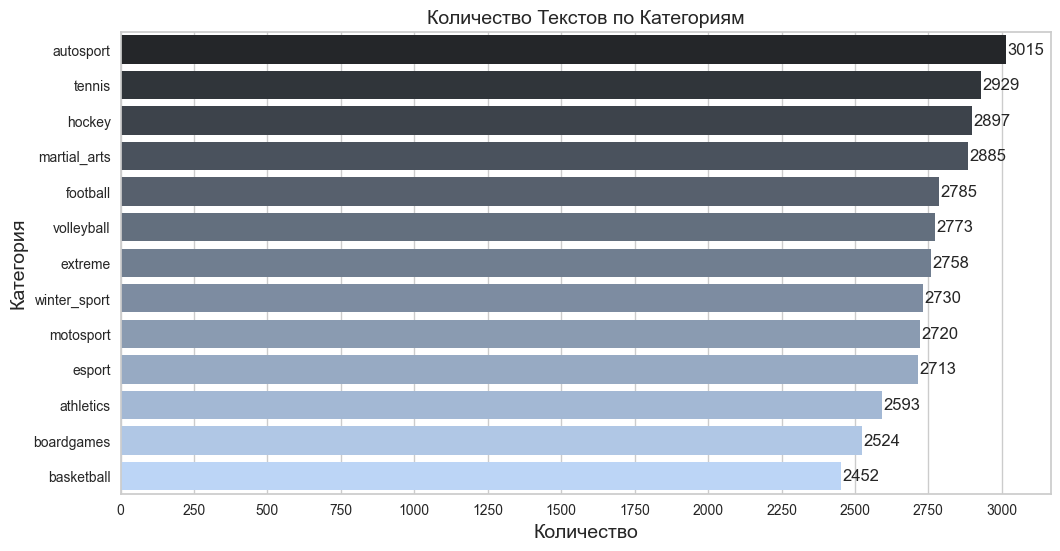

In [12]:
plt.figure(figsize=(12, 6))

sr = train_data.category.value_counts()
xp, yp = np.array(sr), np.array(sr.index)

ax = sns.barplot(x=xp, y=yp, hue=yp, orient='h', color='#b3d4ff', palette='dark:#b3d4ff')
for i, (value, category) in enumerate(zip(xp, yp)):
    ax.text(value+5, i, f'{value}', va='center')  

ax.set_xlabel('Количество', fontsize=14)
ax.set_ylabel('Категория', fontsize=14)
ax.set_title('Количество Текстов по Категориям', fontsize=14)
ax.set_xticks(np.arange(0, 3001, 250))

plt.show()

Построим гистограмму распределения количества символов в предложениях

In [13]:
train_data['length'] = train_data['text'].str.len()
train_data.head(3)

,oid,category,text,category_le,length
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,12,65
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,5,246
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,6,704


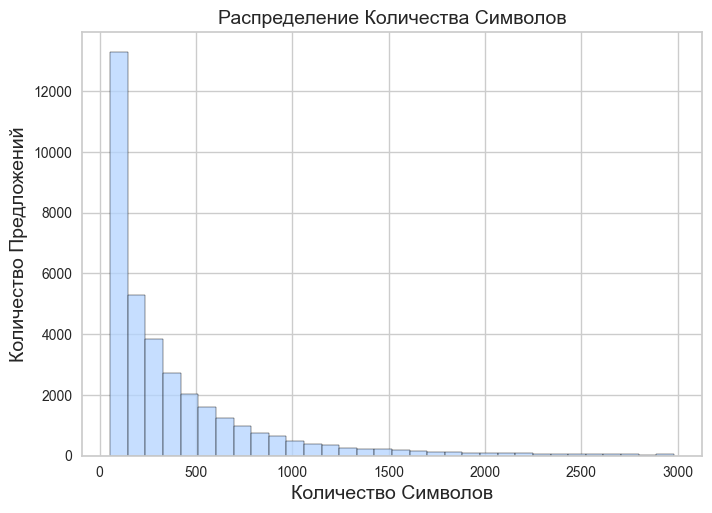

In [14]:
sns.histplot(data=train_data, x='length', bins=32, color='#b3d4ff')
plt.grid(True)
plt.title('Распределение Количества Символов', fontsize=14)
plt.xlabel('Количество Символов', fontsize=14)
plt.ylabel('Количество Предложений', fontsize=14)
plt.show()

Как мы видим, распределение категорий довольно близко к равномерному. В таком случае можно использовать метрику `accuracy_score()` т.к. даже при выборе самого популярного класса точность будет достаточно низкой. Также не стоит забывать про метрику `score()`, предложенную создателями датасета. В любом случае, по своему механизму работы она похожа на `accuracy_score()`, так что мы ничего не теряем. Теперь посмотрим на самые популярные и менее популярные слова в текстах.

In [15]:
word_list = re.findall(r'\b\w{2,}\b', ' '.join(train_data.text.to_numpy()).lower())
df_words = pd.DataFrame(word_list, columns=['word']).groupby('word').size()
df_words = df_words.reset_index(name='count').sort_values('count', ascending=False)
pd.concat([df_words.head(25).reset_index(drop=True), df_words.tail(25).reset_index(drop=True)], axis=1)

,word,count,word,count
0,на,39638,манипулировал,1
1,не,23635,мансабын,1
2,что,19917,мансап,1
3,33,19756,манфорд,1
4,по,14054,манси,1
5,за,11337,мануэля,1
6,это,10827,мануэлю,1
7,для,9919,мануэла,1
8,из,9508,мануальный,1
9,но,9212,мануалы,1


В дополнение ко всему, нужно исключить слова, которые не неут никакой смысловой нагрузки. Для этого используем библиотеку `nltk` и `nltk.corpus.stopwords`.

In [16]:
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')
russian_stopwords.extend(np.arange(0, 100).astype(str))  # исключим числа
russian_stopwords.extend(['это', 'tokentokenoid', 'rtokenoid', 'tokenoid', 'tokenoidtokenoid', 'votokenoid'])
russian_stopwords[:10], len(russian_stopwords)

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со'], 257)

In [17]:
fig = px.treemap(df_words[~df_words.word.isin(russian_stopwords)].head(275), path=['word'], values='count')
fig.show()

Одними из самых популярных слов оказались предлоги, они не влияют на качество классификации, так как присутствуют в большинстве классов. Они являются шумом, и их можно удалить.

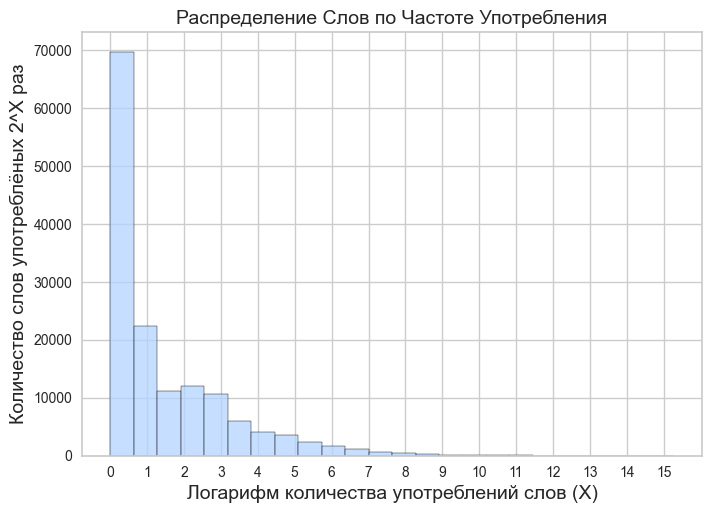

In [18]:
sns.histplot(x=np.log2(df_words['count']), bins=24, color='#b3d4ff')
plt.xticks(np.arange(0, 16, 1))

plt.title('Распределение Слов по Частоте Употребления', fontsize=14)
plt.xlabel('Логарифм количества употреблений слов (X)', fontsize=14)
plt.ylabel('Количество слов употреблёных 2^X раз', fontsize=14)
plt.grid(True, which='minor')

plt.show()

Большинство слов используются всего 1-4 раз.

Теперь посмотрим на распределение количества символов для каждого класса

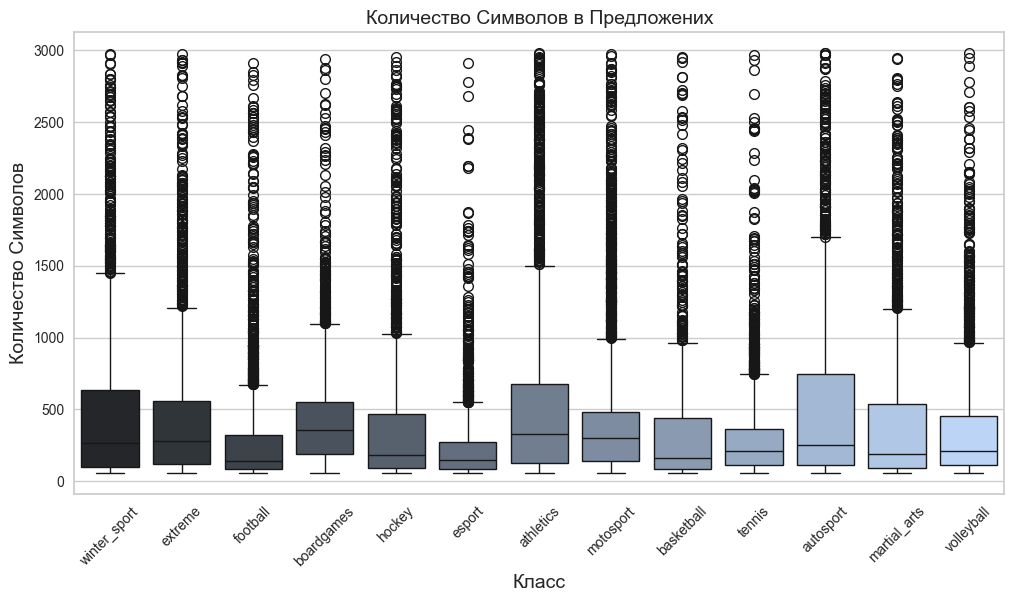

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_data, x='category', y='length', hue='category', color='#b3d4ff', palette='dark:#b3d4ff')

plt.title('Количество Символов в Предложених', fontsize=14)
plt.xlabel('Класс', fontsize=14)
plt.ylabel('Количество Символов', fontsize=14)
plt.xticks(rotation=45)

plt.show()

### 2.3 Финальная Подготовка Датасета

Ещё раз инициализируем стоп слова

In [20]:
russian_stopwords = stopwords.words('russian')
russian_stopwords.extend(['tokentokenoid', 'rtokenoid', 'tokenoid', 'tokenoidtokenoid', 'votokenoid', 'evgentokenoid', '–'])
russian_stopwords[:10], len(russian_stopwords)

(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со'], 158)

In [21]:
allowed_chars = list(chr(i) for i in [*np.arange(ord('а'), ord('я')+1), *np.arange(ord('А'), ord('Я')+1), ord('ё'), ord('Ё')]) + list(string.ascii_letters)
russian_stopwords.extend(string.punctuation)
russian_stopwords.extend(allowed_chars)
russian_stopwords[:10], len(russian_stopwords)

(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со'], 308)

Пишем собственную функцию для токенизации предложений, удаления стоп слов, знаков и лемматизации слов

In [22]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

In [23]:
def is_sublist(lst1, lst2):
    return set(lst1) <= set(lst2)

def tokenize(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    
    tokens = [
        i.lemma.strip() for i in doc.tokens
        if i.lemma.strip() not in russian_stopwords and
        not i.lemma.strip().isnumeric()
        # is_sublist(list(i.lemma.strip()), allowed_chars)
    ]

    return tokens

Добавляем новый столбец с обработанным текстом

In [24]:
train_data['text_tokenized'] = [tokenize(i) for i in tqdm(train_data.text)]
# test_data['text_tokenized'] = [tokenize(i) for i in tqdm(test_data.text)]

100%|██████████| 35774/35774 [08:48<00:00, 67.70it/s] 


Поделим данные на тренировочную, валидационную и тестовую выборки.

In [25]:
X, y = train_data.text_tokenized.to_numpy(), train_data.category_le.to_numpy()
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val)
del X_test_val, y_test_val  # удалим эти переменные, чтобы их после случайно не использовать

## <hr>Глава 3. Обучение моделей для классификации текстов

Для векторизации текстов и оценки важности слова в контексте документа будем использовать статистическую меру `tf-idf`. Для оптимизации работы используем функцию для обучения и оценки моделей с использованием `Pipeline`.

In [61]:
models = [
    LogisticRegression(n_jobs=-1, random_state=42),
    ComplementNB(),
    SGDClassifier(n_jobs=-1, random_state=42),
    RandomForestClassifier(n_jobs=-1, random_state=42),
    RidgeClassifier(random_state=42),
    KNeighborsClassifier(n_neighbors=10, n_jobs=-1),
    LinearSVC(dual='auto'),
    CalibratedClassifierCV(n_jobs=-1),
    MultinomialNB(),
]

In [77]:
def fit_model(user_model):
    model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
        ('model', user_model),
    ]).fit(X_train, y_train)

    y_pred = model.predict(X_val)
    score = accuracy_score(y_pred, y_val)
    return model, score

def cv_model(user_model):
    model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)),
        ('model', user_model),
    ]).fit(X_train, y_train)

    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy').mean()

    return model, score

Модели из списка ниже я подбирал руками по двум критериям: точность предсказаний и скорость обучения. Также для сравнения я включил несколькостандартных решений для классификации.

### 3.1 LogisticRegression

In [63]:
%%time
model, score = cv_model(models[0])
print(f'{model[1].__class__.__name__}: {score:.4f}')

LogisticRegression: 0.8391
CPU times: user 1.42 s, sys: 195 ms, total: 1.61 s
Wall time: 20 s


### 3.2 ComplementNB

In [64]:
%%time
model, score = cv_model(models[1])
print(f'{model[1].__class__.__name__}: {score:.4f}')

ComplementNB: 0.8573
CPU times: user 1.43 s, sys: 31.9 ms, total: 1.46 s
Wall time: 1.48 s


### 3.3 SGDClassifier

In [65]:
%%time
model, score = cv_model(models[2])
print(f'{model[1].__class__.__name__}: {score:.4f}')

SGDClassifier: 0.8612
CPU times: user 2.29 s, sys: 32.1 ms, total: 2.32 s
Wall time: 1.57 s


### 3.4 RandomForestClassifier

In [66]:
%%time
model, score = cv_model(models[3])
print(f'{model[1].__class__.__name__}: {score:.4f}')

RandomForestClassifier: 0.7925
CPU times: user 2min 10s, sys: 556 ms, total: 2min 11s
Wall time: 20.3 s


### 3.5 RidgeClassifier

In [67]:
%%time
model, score = cv_model(models[4])
print(f'{model[1].__class__.__name__}: {score:.4f}')

RidgeClassifier: 0.8635
CPU times: user 7.66 s, sys: 68.5 ms, total: 7.73 s
Wall time: 3.69 s


### 3.6 KNeighborsClassifier

In [68]:
%%time
model, score = cv_model(models[5])
print(f'{model[1].__class__.__name__}: {score:.4f}')

KNeighborsClassifier: 0.7985
CPU times: user 11.8 s, sys: 2.75 s, total: 14.5 s
Wall time: 8.49 s


### 3.7 LinearSVC

In [69]:
%%time
model, score = cv_model(models[6])
print(f'{model[1].__class__.__name__}: {score:.4f}')

LinearSVC: 0.8589
CPU times: user 2.71 s, sys: 40.5 ms, total: 2.75 s
Wall time: 2.77 s


### 3.8 CalibratedClassifierCV

In [70]:
%%time
model, score = cv_model(models[7])
print(f'{model[1].__class__.__name__}: {score:.4f}')

CalibratedClassifierCV: 0.8616
CPU times: user 1.54 s, sys: 162 ms, total: 1.7 s
Wall time: 5.4 s


### 3.9 MultinomialNB

In [71]:
%%time
model, score = cv_model(models[8])
print(f'{model[1].__class__.__name__}: {score:.4f}')

MultinomialNB: 0.8261
CPU times: user 1.48 s, sys: 20.9 ms, total: 1.5 s
Wall time: 1.51 s


### 3.10 Обучение Всех Моделей

In [72]:
print(' ' + '_'*49)
all_models_scores = []
for model in models:
    model_name = model.__class__.__name__
    print(f'| Модель {model_name:<40} |')
    
    start_time = time.time()
    model, score = cv_model(model)
    end_time = time.time()
    learning_time = end_time - start_time


    print(f'|   {score=:.4f} {learning_time=:<18.4f} |', end=f'\n {'_'*49}\n')
    all_models_scores.append({'name': model_name, 'score': score, 'time': learning_time})

 _________________________________________________
| Модель LogisticRegression                       |
|   score=0.8391 learning_time=23.7442            |
 _________________________________________________
| Модель ComplementNB                             |
|   score=0.8573 learning_time=1.4362             |
 _________________________________________________
| Модель SGDClassifier                            |
|   score=0.8612 learning_time=1.4762             |
 _________________________________________________
| Модель RandomForestClassifier                   |
|   score=0.7925 learning_time=20.5027            |
 _________________________________________________
| Модель RidgeClassifier                          |
|   score=0.8635 learning_time=3.5577             |
 _________________________________________________
| Модель KNeighborsClassifier                     |
|   score=0.7985 learning_time=8.0735             |
 _________________________________________________
| Модель LinearSVC 

In [75]:
df_models = pd.DataFrame(all_models_scores)
df_models = df_models.sort_values('score', ascending=False).reset_index(drop=True)
df_models

,name,score,time
0,RidgeClassifier,0.863539,3.557747
1,CalibratedClassifierCV,0.861582,4.606375
2,SGDClassifier,0.861210,1.476221
3,LinearSVC,0.858927,2.630327
4,ComplementNB,0.857296,1.436201
5,LogisticRegression,0.839079,23.744162
6,MultinomialNB,0.826127,1.343138
7,KNeighborsClassifier,0.798546,8.073523
8,RandomForestClassifier,0.792490,20.502750


Посмотрим на лучшую модель, это метрика для оценивания моделей, предложенная создателями датасета

In [85]:
best_model, score = cv_model(models[4])
y_pred = best_model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       518
           1       0.89      0.87      0.88       603
           2       0.93      0.88      0.90       490
           3       0.91      0.97      0.94       505
           4       0.82      0.81      0.81       543
           5       0.72      0.79      0.76       552
           6       0.84      0.85      0.84       557
           7       0.91      0.87      0.89       580
           8       0.82      0.80      0.81       577
           9       0.90      0.92      0.91       544
          10       0.96      0.95      0.96       586
          11       0.92      0.86      0.89       554
          12       0.87      0.89      0.88       546

    accuracy                           0.87      7155
   macro avg       0.88      0.87      0.87      7155
weighted avg       0.87      0.87      0.87      7155



Модель ошибается примерно одинаково на каждом классе

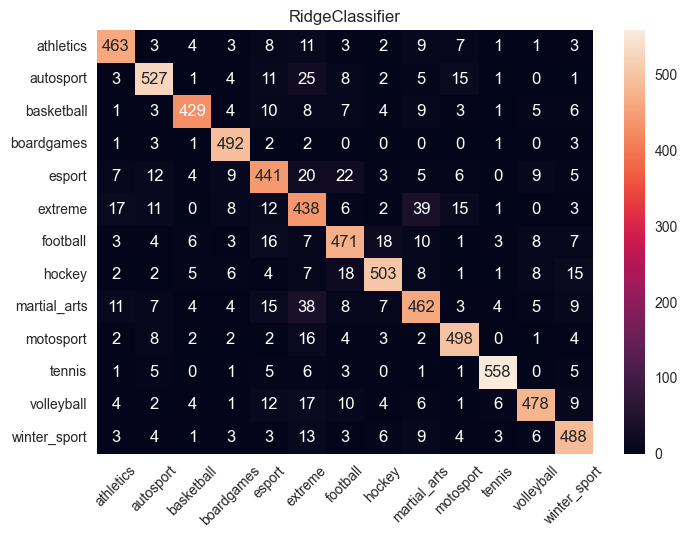

In [86]:
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(best_model[1].__class__.__name__)
plt.xticks(rotation=45)
plt.show()

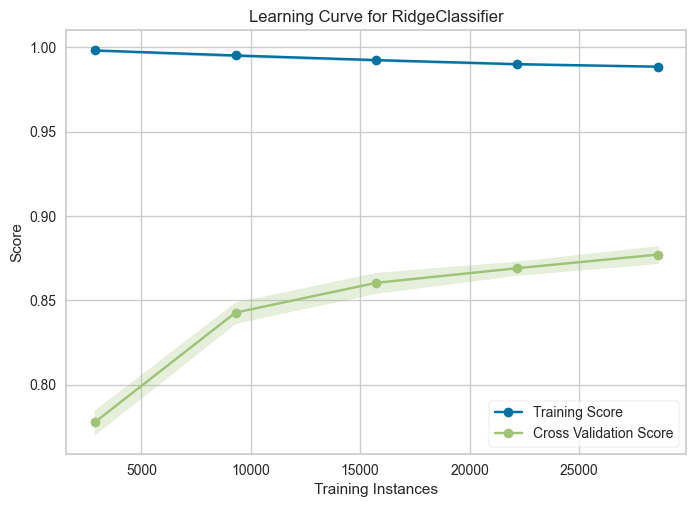

CPU times: user 40.9 s, sys: 477 ms, total: 41.3 s
Wall time: 21.3 s


In [87]:
%%time
visualizer = LearningCurve(best_model, scoring='accuracy').fit(X, y).show()

Но тут возникает проблема – переобучение, её мы будем убирать при помощи регуляризации и оптимизации параметров

### 3.11 Результаты и выводы

In [88]:
df_models

,name,score,time
0,RidgeClassifier,0.863539,3.557747
1,CalibratedClassifierCV,0.861582,4.606375
2,SGDClassifier,0.861210,1.476221
3,LinearSVC,0.858927,2.630327
4,ComplementNB,0.857296,1.436201
5,LogisticRegression,0.839079,23.744162
6,MultinomialNB,0.826127,1.343138
7,KNeighborsClassifier,0.798546,8.073523
8,RandomForestClassifier,0.792490,20.502750


Судя по датафрейму, мы получили хорошие результаты для классификации по 13 классам. К слову, некоторые стандартные модели отсутствуют в списке по причине очень долгого обучения и низких метрик, к примеру: `MLPClassifier`, `GradientBoostingClassifier`, `SVC` и т.п.

## <hr>Глава 4. Улучшение и усовершенствование моделей

### 4.1 Выбор нескольких наиболее перспективных моделей на основе полученных результатов

Исходя из проведённых тестов, можно выделить несколько моделей, которые очнь хорошо себя показали

Ими являются:
* `RidgeClassifier`
* `CalibratedClassifierCV`
* `LinearSVC`
* `SGDClassifier`
* `ComplementNB`

Так как все модели обучаются довольно быстро, следующим шагом можно найти оптимальные гиперпараметры для каждой

### 4.2 Применение Grid Search и поиск оптимальных гиперпараметров